<a name="top"> <h1>01. ML Models</h1> <a>

<p>Análisis de sentimiento: Tweets<br />
<strong>Trabajo de Fin de Master</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>


<hr style="border:1px solid gray">

### Estructura

[1. Librerias utilizadas y funciones](#librerias) 

[2. Introducción ](#introduccion) 

   - Objetivo de negocio.

[3. Yelp Dataset ](#yelp) 

   - Información del dataset
   - Características del dataset


[4. Transformación del formato de ficheros](#transformacion) 


[5. Transformación de datos](#datos)

   - Business
       - Carga del fichero
       - Transformación de los datos
       - Exportación de ficheros procesados

<hr style="border:1px solid gray">

# <a name="librerias"> 1. Librerias utilizadas y funciones <a>


Importamos las librerias a utilizar para el preprocesamiento:

In [1]:
# Import basic libraries.

import pandas as pd
import numpy as np
import string
import pickle
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
import seaborn as sns

# Import ML libraries.

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score   
from xgboost import XGBClassifier



# Import libraries for evaluation.

from sklearn.model_selection import GridSearchCV

# <a name="lectura"> 2. Lectura del dataframe y preparación de los datos<a>


## 2.1. Lectura del DF

In [2]:
#Import parquet file.

tweets = pd.read_parquet('../../data/processed/tweets.parquet')


# Show the head of the dataframe.

tweets.head()

,text,sentiment,SentimentText_clean
0,id have responded if i were going,0,id responded going
1,sooo sad i will miss you here in san diego,2,sooo sad miss san diego
2,my boss is bullying me,2,boss bullying
3,what interview leave me alone,2,interview leave alone
4,sons of why couldnt they put them on the rel...,2,sons couldnt put releases already bought


## 2.2. Preparación de los datos

Preparamos los datos para que puedan ser introducidos dentro de los modelos, separando en X el texto y en Y las puntuaciones.

In [3]:
# Define X and y.

X = tweets.SentimentText_clean
y = tweets.sentiment

# Split into train and test.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# <a name="modelos"> 3. Evaluación de los modelos<a>


## 3.1. Support Vector Classifier

In [4]:
# Set up the pipeline.

tfidf = TfidfVectorizer(stop_words="english",max_df=0.99,min_df=0.01)
svc = SVC(probability=True)
model = make_pipeline(tfidf, svc)

# Training the model.

model.fit(x_train, y_train)

# Prediction.
preds= model.predict(x_test)
predict_probabilities = model.predict_proba(x_test)

In [5]:
# Evaluation
print(classification_report(y_test,preds))
print(metrics.accuracy_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.52      0.78      0.63      2252
           1       0.73      0.57      0.64      1719
           2       0.60      0.32      0.41      1526

    accuracy                           0.59      5497
   macro avg       0.62      0.56      0.56      5497
weighted avg       0.61      0.59      0.57      5497

0.5850463889394215


In [6]:
print(confusion_matrix(y_test,preds))

[[1752  263  237]
 [ 656  983   80]
 [ 936  109  481]]


In [7]:
# Save the model.

pickle.dump(model, open('../../models/svc_model_tweets.pkl', 'wb'))

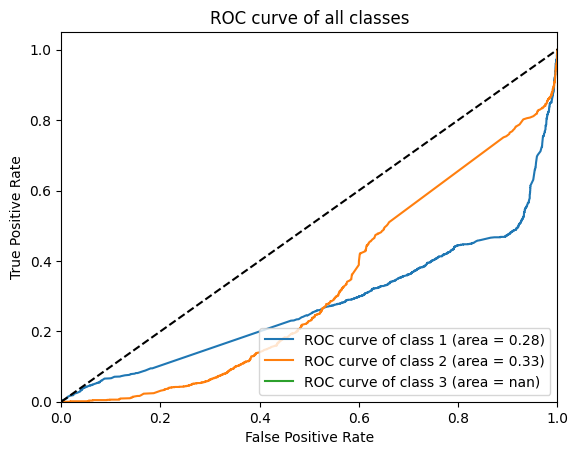

In [14]:
# Compute ROC curve and ROC area for each class

fpr = dict()

tpr = dict()

roc_auc = dict()

for i in range(3):
    
        fpr[i], tpr[i], _ = roc_curve(y_test, predict_probabilities[:, i], pos_label=i+1)
    
        roc_auc[i] = auc(fpr[i], tpr[i])
        
# Plot of the ROC curve of all classes in the same plot.

for i in range(3):
        
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i+1, roc_auc[i]))
        
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC curve of all classes')

plt.legend(loc="lower right")

plt.show()


## 3.2. MultinomialNB

In [5]:
# Set up the pipeline.

tfidf = TfidfVectorizer(stop_words="english",max_df=0.99,min_df=0.01)

In [6]:
# Entrenar el modelo
clf = MultinomialNB()

model = make_pipeline(tfidf, clf)
#Training
model.fit(x_train, y_train)

#Prediccion sobre test
preds= model.predict(x_test )
predict_probabilities = model.predict_proba(x_test)


In [7]:
# Evaluation
print(classification_report(y_test,preds))
print(metrics.accuracy_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.51      0.86      0.64      2252
           1       0.75      0.51      0.61      1719
           2       0.70      0.24      0.35      1526

    accuracy                           0.58      5497
   macro avg       0.65      0.53      0.53      5497
weighted avg       0.64      0.58      0.55      5497

0.5764962706931054


[[1931  200  121]
 [ 807  877   35]
 [1079   86  361]]


<Axes: >

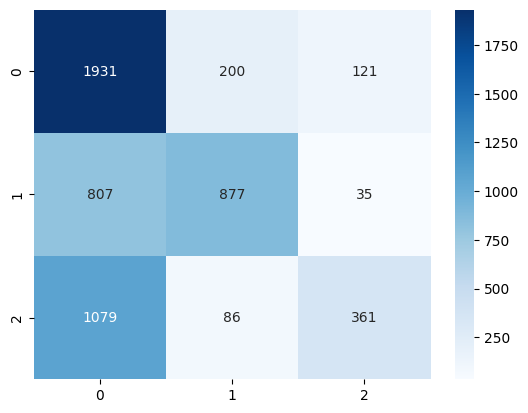

In [8]:
print(confusion_matrix(y_test,preds))

# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


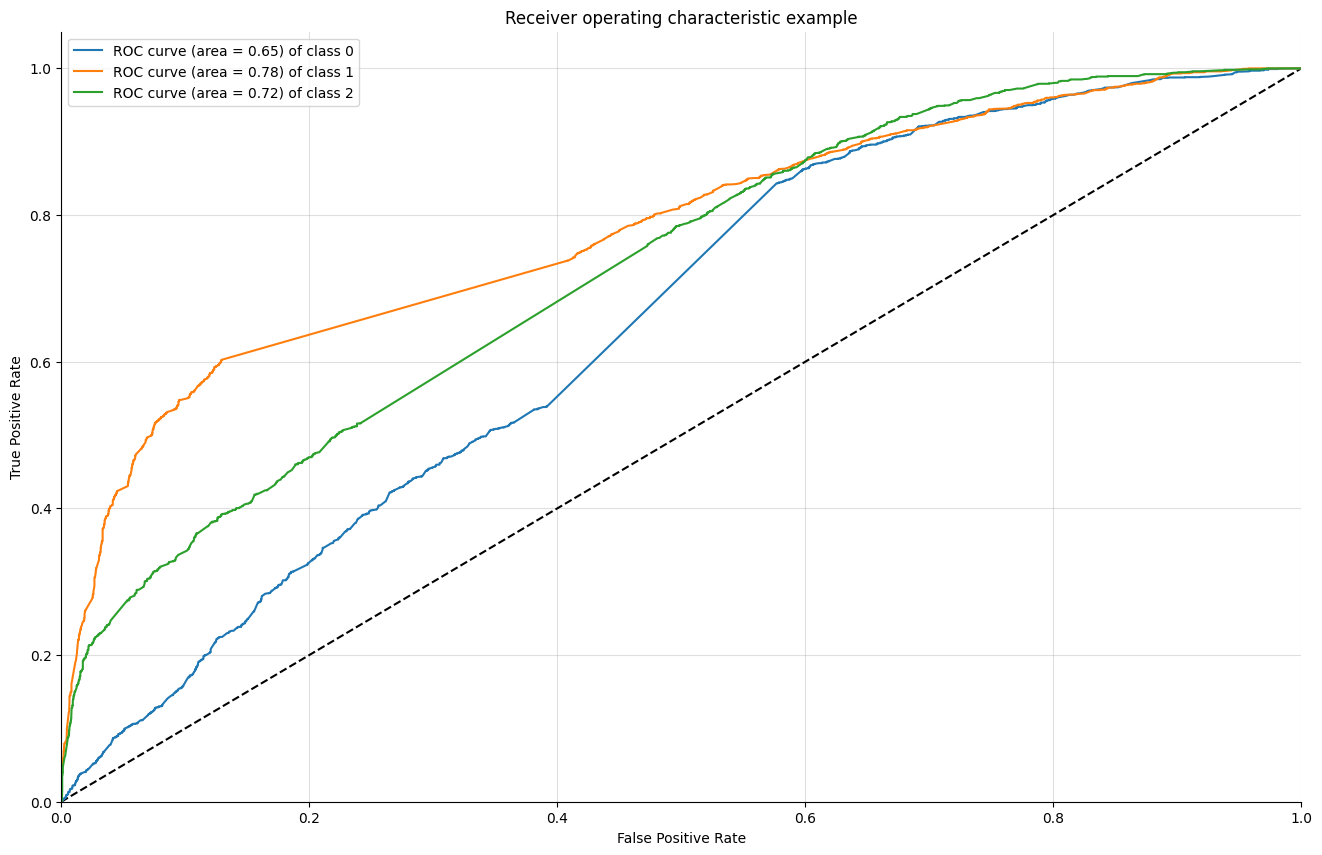

In [9]:
#Function to plot the ROC curve of a multi-class classifier.

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    
        y_score = clf.predict_proba(X_test)
        
        # structures
        fpr = dict()
        
        tpr = dict()
        
        roc_auc = dict()
        
        # calculate dummies once
        
        y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
        
        for i in range(n_classes):
                
                fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
                
                roc_auc[i] = auc(fpr[i], tpr[i])
                
        # roc for each class
        
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.plot([0, 1], [0, 1], 'k--')
        
        ax.set_xlim([0.0, 1.0])
        
        ax.set_ylim([0.0, 1.05])
        
        ax.set_xlabel('False Positive Rate')
        
        ax.set_ylabel('True Positive Rate')
        
        ax.set_title('Receiver operating characteristic example')
        
        for i in range(n_classes):
                
                ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) of class %i' % (roc_auc[i], i))
                
        ax.legend(loc="best")
        
        ax.grid(alpha=.4)
        
        sns.despine()
        
        plt.show()

# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))

## 3.3. XGB Classifier

In [10]:
# Entrenar el modelo

xgb = XGBClassifier()

model = make_pipeline(tfidf, xgb)

#Training

model.fit(x_train, y_train)

#Prediccion sobre test

preds= model.predict(x_test )
predict_probabilities = model.predict_proba(x_test)

[[1790  263  199]
 [ 660  986   73]
 [ 970  115  441]]


<Axes: >

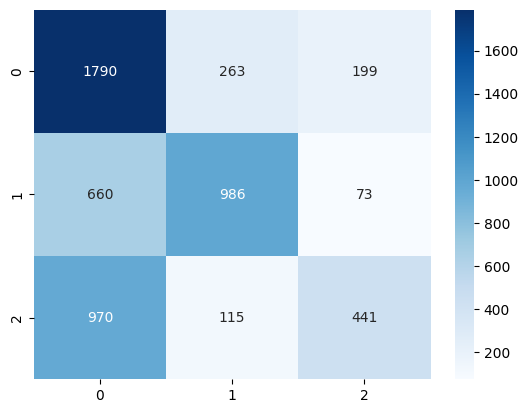

In [11]:
print(confusion_matrix(y_test,preds))

# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


In [12]:
# Evaluation
print(classification_report(y_test,preds))
print(metrics.accuracy_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.52      0.79      0.63      2252
           1       0.72      0.57      0.64      1719
           2       0.62      0.29      0.39      1526

    accuracy                           0.59      5497
   macro avg       0.62      0.55      0.55      5497
weighted avg       0.61      0.59      0.57      5497

0.5852283063489175


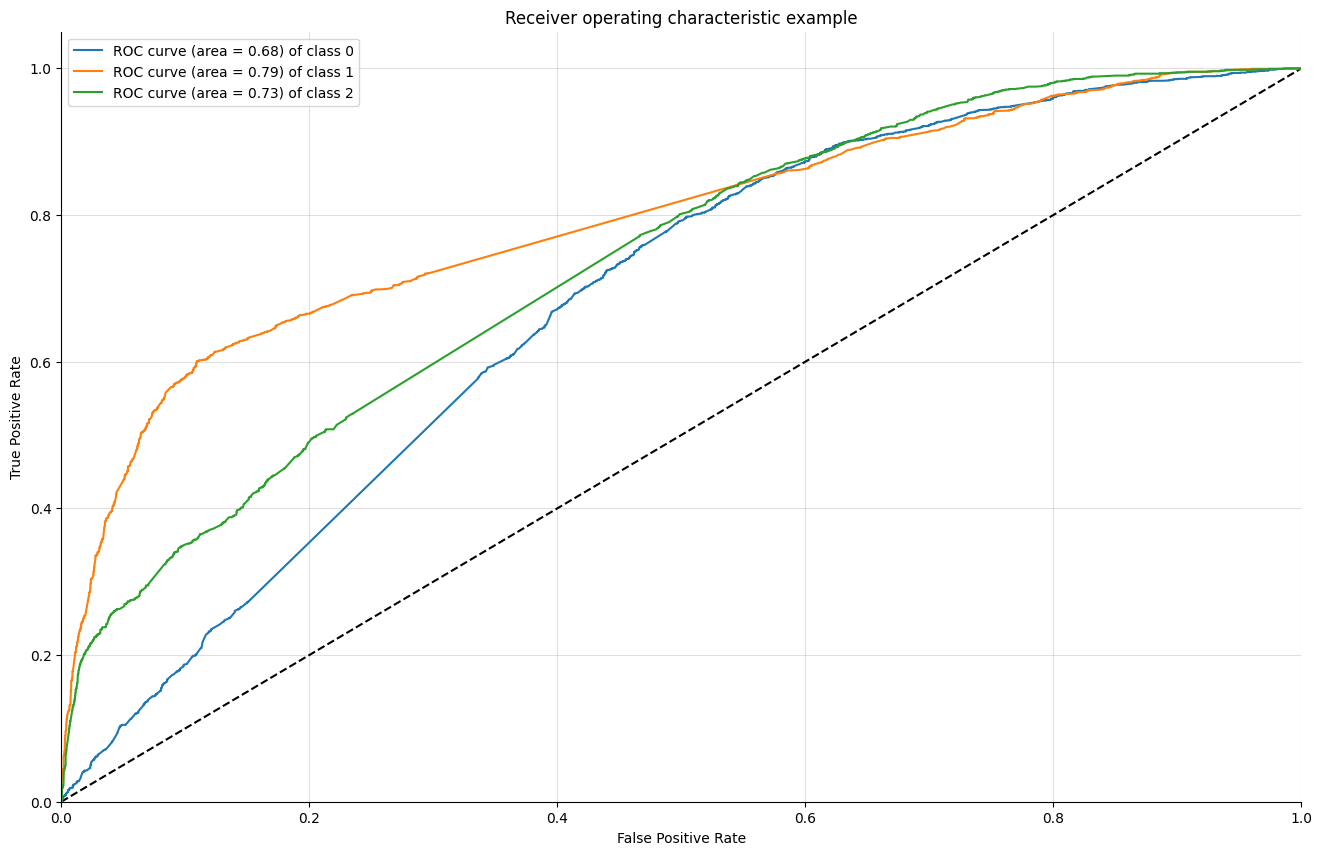

In [13]:
# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))

## 3.4. Random Forest

In [14]:
# Entrenar el modelo

rf = RandomForestClassifier()

model = make_pipeline(tfidf, rf)

#Training

model.fit(x_train, y_train)

#Prediccion sobre test

preds= model.predict(x_test )
predict_probabilities = model.predict_proba(x_test)

In [15]:
# Evaluation
print(classification_report(y_test,preds))
print(metrics.accuracy_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.53      0.74      0.62      2252
           1       0.71      0.57      0.63      1719
           2       0.56      0.35      0.43      1526

    accuracy                           0.58      5497
   macro avg       0.60      0.55      0.56      5497
weighted avg       0.59      0.58      0.57      5497

0.5795888666545388


[[1668  280  304]
 [ 616  982  121]
 [ 861  129  536]]


<Axes: >

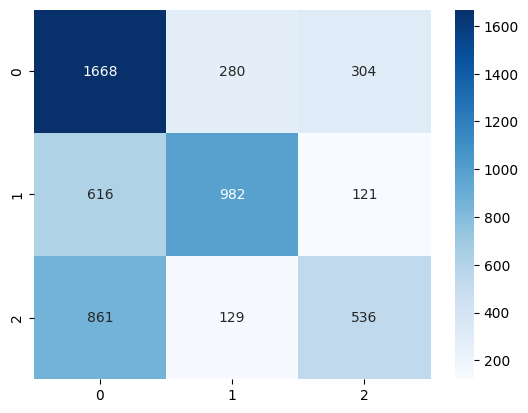

In [16]:
print(confusion_matrix(y_test,preds))

# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


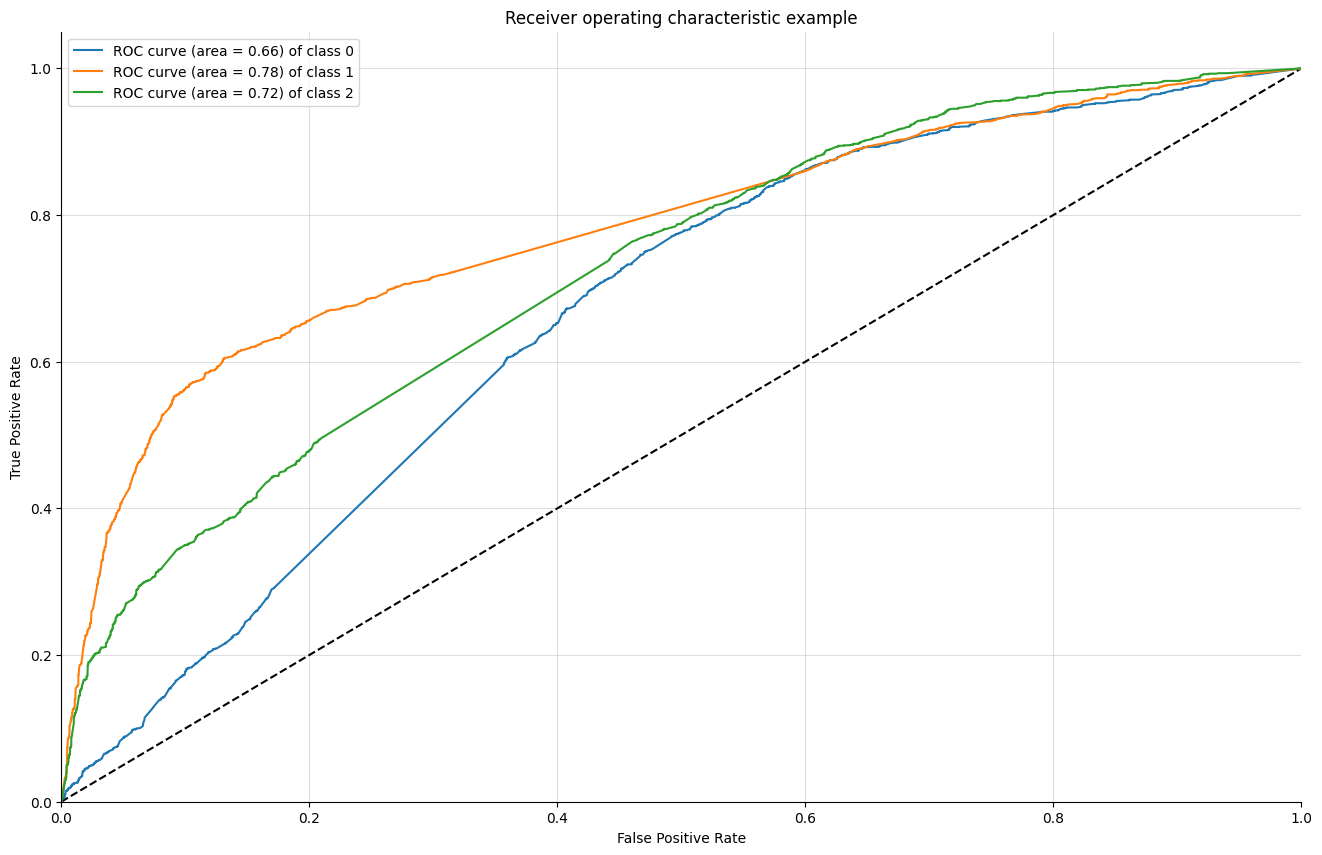

In [17]:
# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))


## 3.4. Logistic Regression

In [18]:
# Entrenar el modelo

lr = LogisticRegression()

model = make_pipeline(tfidf, lr)

#Training

model.fit(x_train, y_train)

#Prediccion sobre test

preds= model.predict(x_test )
predict_probabilities = model.predict_proba(x_test)

In [19]:
# Evaluation
print(classification_report(y_test,preds))
print(metrics.accuracy_score(y_test,preds))

              precision    recall  f1-score   support

           0       0.52      0.78      0.63      2252
           1       0.73      0.58      0.64      1719
           2       0.60      0.30      0.40      1526

    accuracy                           0.59      5497
   macro avg       0.62      0.55      0.56      5497
weighted avg       0.61      0.59      0.57      5497

0.585955975986902


[[1766  265  221]
 [ 645  994   80]
 [ 953  112  461]]


<Axes: >

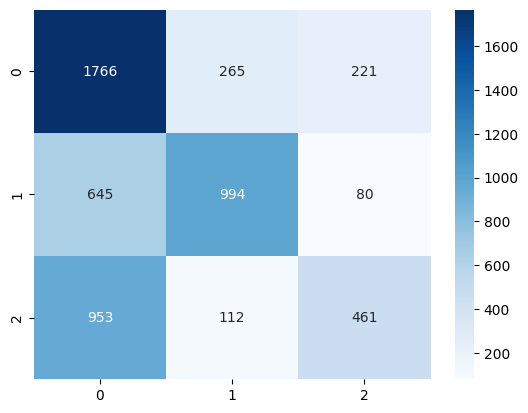

In [20]:
print(confusion_matrix(y_test,preds))

# Confusion matrix.

conf_mat = confusion_matrix(y_test, preds)

# Plot the heatmap.

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')


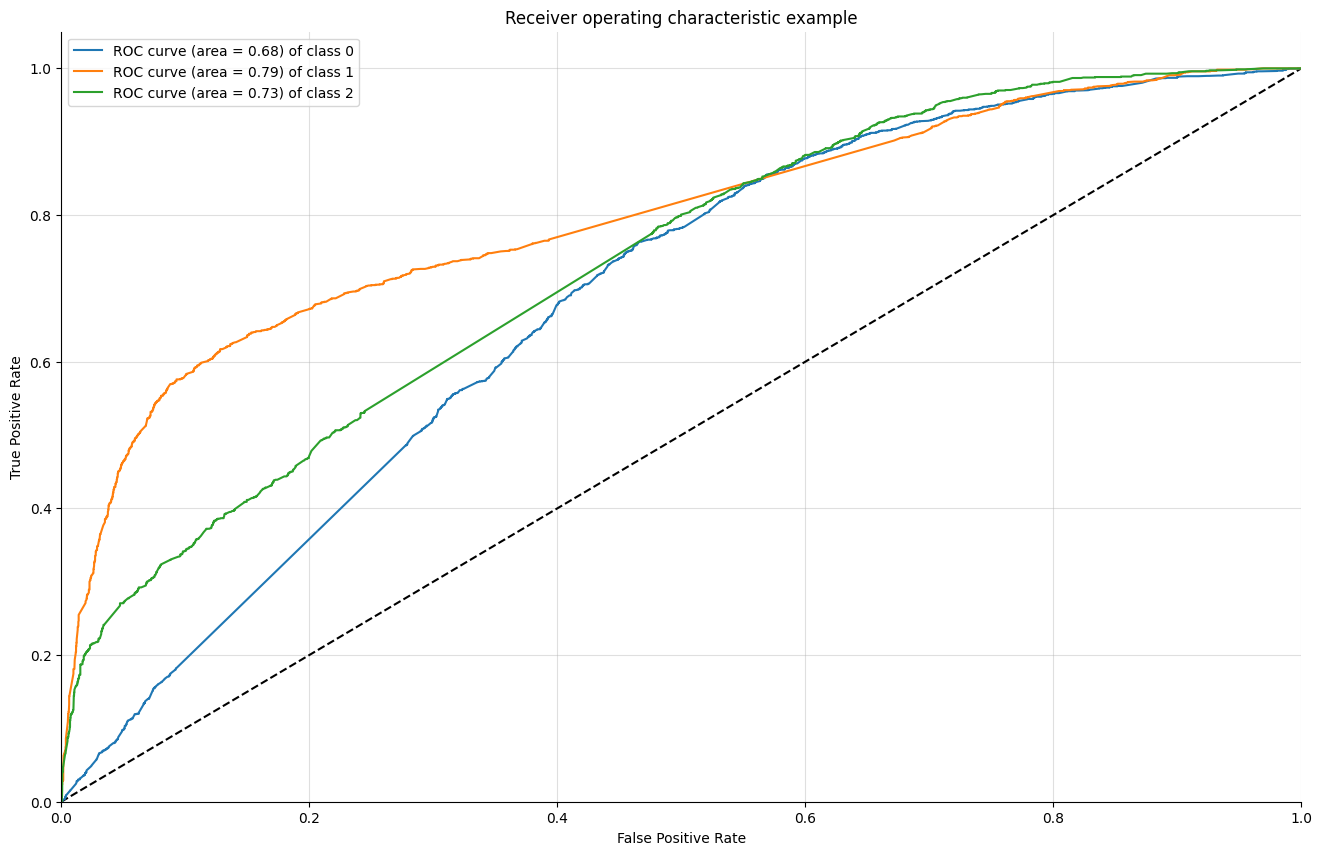

In [22]:
# Plot the ROC curve.

plot_multiclass_roc(model, x_test, y_test, n_classes=3, figsize=(16, 10))


In [4]:
# Create a table with the results.

results = pd.DataFrame({'Model':['SVC', 'MultinomialNB', 'XGBClassifier', 'RandomForestClassifier', 'LogisticRegression'],

                        'Accuracy':[0.5852, 0.575, 0.583, 0.567, 0.5859]})

# Display the table.

results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

,Model,Accuracy
0,LogisticRegression,0.5859
1,SVC,0.5852
2,XGBClassifier,0.5830
3,MultinomialNB,0.5750
4,RandomForestClassifier,0.5670


In [ ]:
# Fine tune the model.

# Create a grid search in ordert to accuracy.

grid = GridSearchCV(model, param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}, cv=5)

# Fit the grid.

grid.fit(x_train, y_train)

# Show the best score.

grid.best_score_

# Show the best parameters.

grid.best_params_